In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

ACTION_HIT = 0
ACTION_STAND = 1
ACTIONS = [ACTION_HIT, ACTION_STAND]

class deck_logic:
    def get_card(self):
        card = np.random.randint(1, 14)
        return min(card, 10)

    def card_value(self, card):
        return 11 if card == 1 else card


# blackjack game
class blackjack:
    def __init__(self, deck=None):
        self.deck = deck or deck_logic()

        # player policy
        self.policy_player = np.zeros(22, dtype=int)
        for i in range(12, 20):
            self.policy_player[i] = ACTION_HIT
        self.policy_player[20:] = ACTION_STAND

        # dealer policy
        self.policy_dealer = np.zeros(22, dtype=int)
        self.policy_dealer[12:17] = ACTION_HIT
        self.policy_dealer[17:22] = ACTION_STAND

    def target_policy_player(self, use_ace_p, sum_p, card_d):
        return self.policy_player[sum_p]

    def play(self, init_state=None, init_action=None):
        deck = self.deck
        sum_p = 0
        traj = []
        use_ace_p = False

        # initialize player and dealer hands
        if init_state is None:
            while sum_p < 12:
                card = deck.get_card()
                sum_p += deck.card_value(card)
                if sum_p > 21:
                    sum_p -= 10
                else:
                    use_ace_p |= (card == 1)
            card_d1 = deck.get_card()
            card_d2 = deck.get_card()
        else:
            use_ace_p, sum_p, card_d1 = init_state
            card_d2 = deck.get_card()

        state = [use_ace_p, sum_p, card_d1]
        sum_d = deck.card_value(card_d1) + deck.card_value(card_d2)
        use_ace_d = 1 in (card_d1, card_d2)
        if sum_d > 21:
            sum_d -= 10

        # player’s turn
        while True:
            if init_action is not None:
                act = init_action
                init_action = None
            else:
                act = self.target_policy_player(use_ace_p, sum_p, card_d1)

            traj.append([(use_ace_p, sum_p, card_d1), act])

            if act == ACTION_STAND:
                break

            card = deck.get_card()
            ace_cnt = int(use_ace_p)
            if card == 1:
                ace_cnt += 1
            sum_p += deck.card_value(card)

            while sum_p > 21 and ace_cnt:
                sum_p -= 10
                ace_cnt -= 1
            if sum_p > 21:
                return state, -1, traj
            use_ace_p = (ace_cnt == 1)

        # dealer’s turn
        while True:
            act = self.policy_dealer[int(sum_d)]
            if act == ACTION_STAND:
                break
            new_card = deck.get_card()
            ace_cnt = int(use_ace_d)
            if new_card == 1:
                ace_cnt += 1
            sum_d += deck.card_value(new_card)
            while sum_d > 21 and ace_cnt:
                sum_d -= 10
                ace_cnt -= 1
            if sum_d > 21:
                return state, 1, traj
            use_ace_d = (ace_cnt == 1)

        # final outcome
        if sum_p > sum_d:
            return state, 1, traj
        elif sum_p == sum_d:
            return state, 0, traj
        else:
            return state, -1, traj


# monte carlo simulator
class simulator:
    def __init__(self, game):
        self.game = game

    def run(self, episodes=500000):
        states_ace = np.zeros((10, 10))
        counts_ace = np.ones((10, 10))
        states_noace = np.zeros((10, 10))
        counts_noace = np.ones((10, 10))

        for _ in tqdm(range(episodes)):
            _, reward, traj = self.game.play()
            for (use_ace, sum_p, card_d), _ in traj:
                if 12 <= sum_p <= 21:
                    ps_idx = sum_p - 12
                    dc_idx = card_d - 1
                    if use_ace:
                        states_ace[ps_idx, dc_idx] += reward
                        counts_ace[ps_idx, dc_idx] += 1
                    else:
                        states_noace[ps_idx, dc_idx] += reward
                        counts_noace[ps_idx, dc_idx] += 1

        vals_ace = states_ace / counts_ace
        vals_noace = states_noace / counts_noace
        return vals_ace, vals_noace

100%|██████████| 500000/500000 [00:02<00:00, 180056.20it/s]


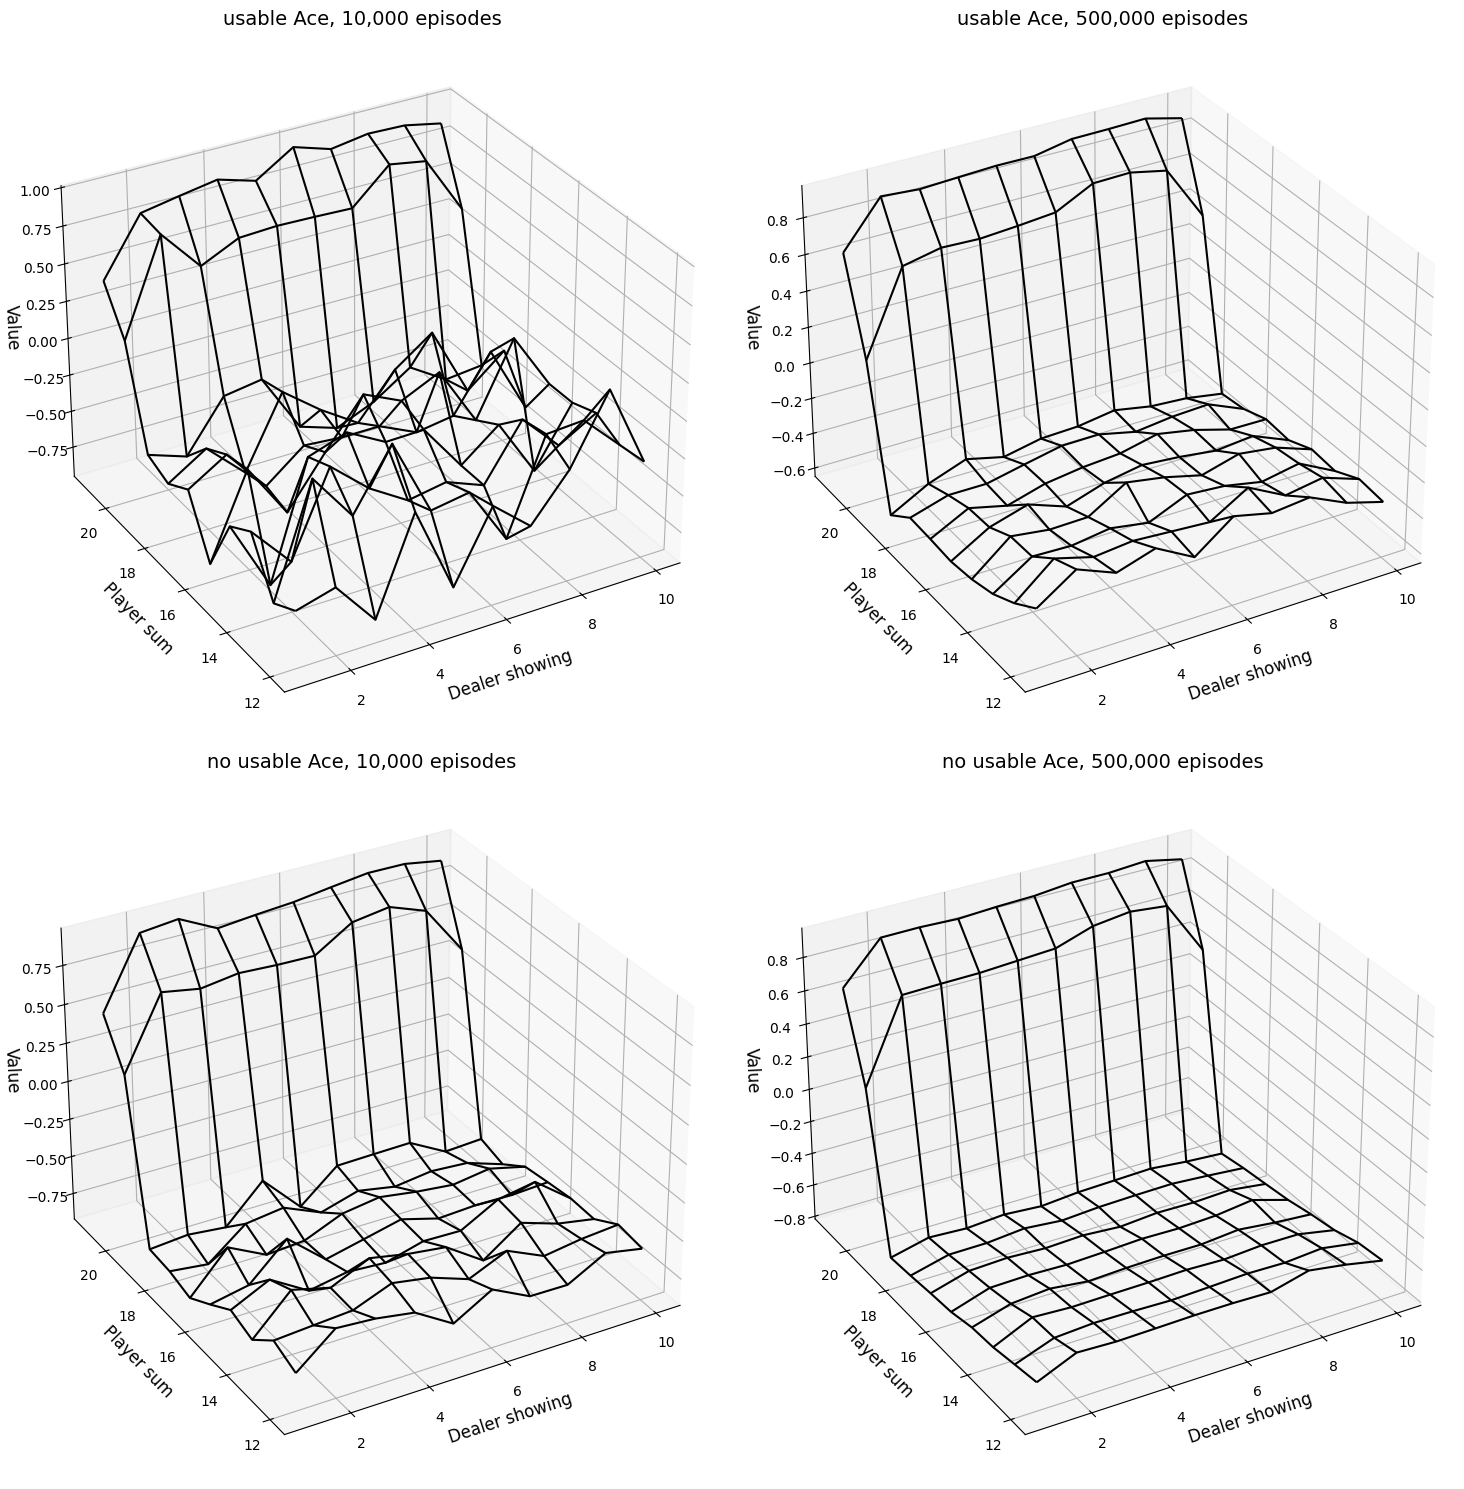

In [8]:
# run simulations
game = blackjack()
sim = simulator(game)

usable_10k, no_10k = sim.run(10000)
usable_500k, no_500k = sim.run(500000)

# prepare data
states = [
    usable_10k,
    usable_500k,
    no_10k,
    no_500k
]
titles = [
    'usable Ace, 10,000 episodes',
    'usable Ace, 500,000 episodes',
    'no usable Ace, 10,000 episodes',
    'no usable Ace, 500,000 episodes'
]

# plot 3d wireframe
X, Y = np.meshgrid(np.arange(1, 11), np.arange(12, 22)) # dealer showing, player sum

fig = plt.figure(figsize=(15, 15))

for idx, (Z, title) in enumerate(zip(states, titles), start=1):
    ax = fig.add_subplot(2, 2, idx, projection='3d')
    ax.plot_wireframe(X, Y, Z, color='black')

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Dealer showing', fontsize=12)
    ax.set_ylabel('Player sum', fontsize=12)
    ax.set_zlabel('Value', fontsize=12)
    ax.view_init(elev=30, azim=-120)

plt.tight_layout()
plt.show()